In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
from math import sqrt


import yfinance as yf

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, Bidirectional
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import RMSprop

In [2]:
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

In [3]:
# Loading the dataset
# From 1 January, 2017 to 31 December, 2022
df = yf.download("AAPL", start="2017-01-01", end="2022-12-31")

[*********************100%%**********************]  1 of 1 completed


In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.023701,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,26.993452,84472400
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.130732,88774400
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.433187,127007600
2017-01-09,29.487499,29.857500,29.485001,29.747499,27.684460,134247600


In [5]:
# Splitting the features and target variables
X = df.drop(['Close'], axis = 1)
y = df[['Close']]

In [6]:
X.head()

,Open,High,Low,Adj Close,Volume
Date,,,,,
2017-01-03,28.950001,29.082500,28.690001,27.023701,115127600
2017-01-04,28.962500,29.127501,28.937500,26.993452,84472400
2017-01-05,28.980000,29.215000,28.952499,27.130732,88774400
2017-01-06,29.195000,29.540001,29.117500,27.433187,127007600
2017-01-09,29.487499,29.857500,29.485001,27.684460,134247600


In [7]:
y.head()

,Close
Date,
2017-01-03,29.037500
2017-01-04,29.004999
2017-01-05,29.152500
2017-01-06,29.477501
2017-01-09,29.747499


In [8]:
# Exploratory Data Analysis

In [9]:
print(f'Shape of the Dataframe: {X.shape}')

Shape of the Dataframe: (1510, 5)


In [10]:
print('Null Values')
print(X.isnull().sum())

Null Values
Open         0
High         0
Low          0
Adj Close    0
Volume       0
dtype: int64


In [11]:
# Number of rows and columns in a grid
df_features = df.columns
num_of_cols = 3
num_of_rows = np.ceil(len(df_features) / num_of_cols)
num_of_rows = int(num_of_rows)

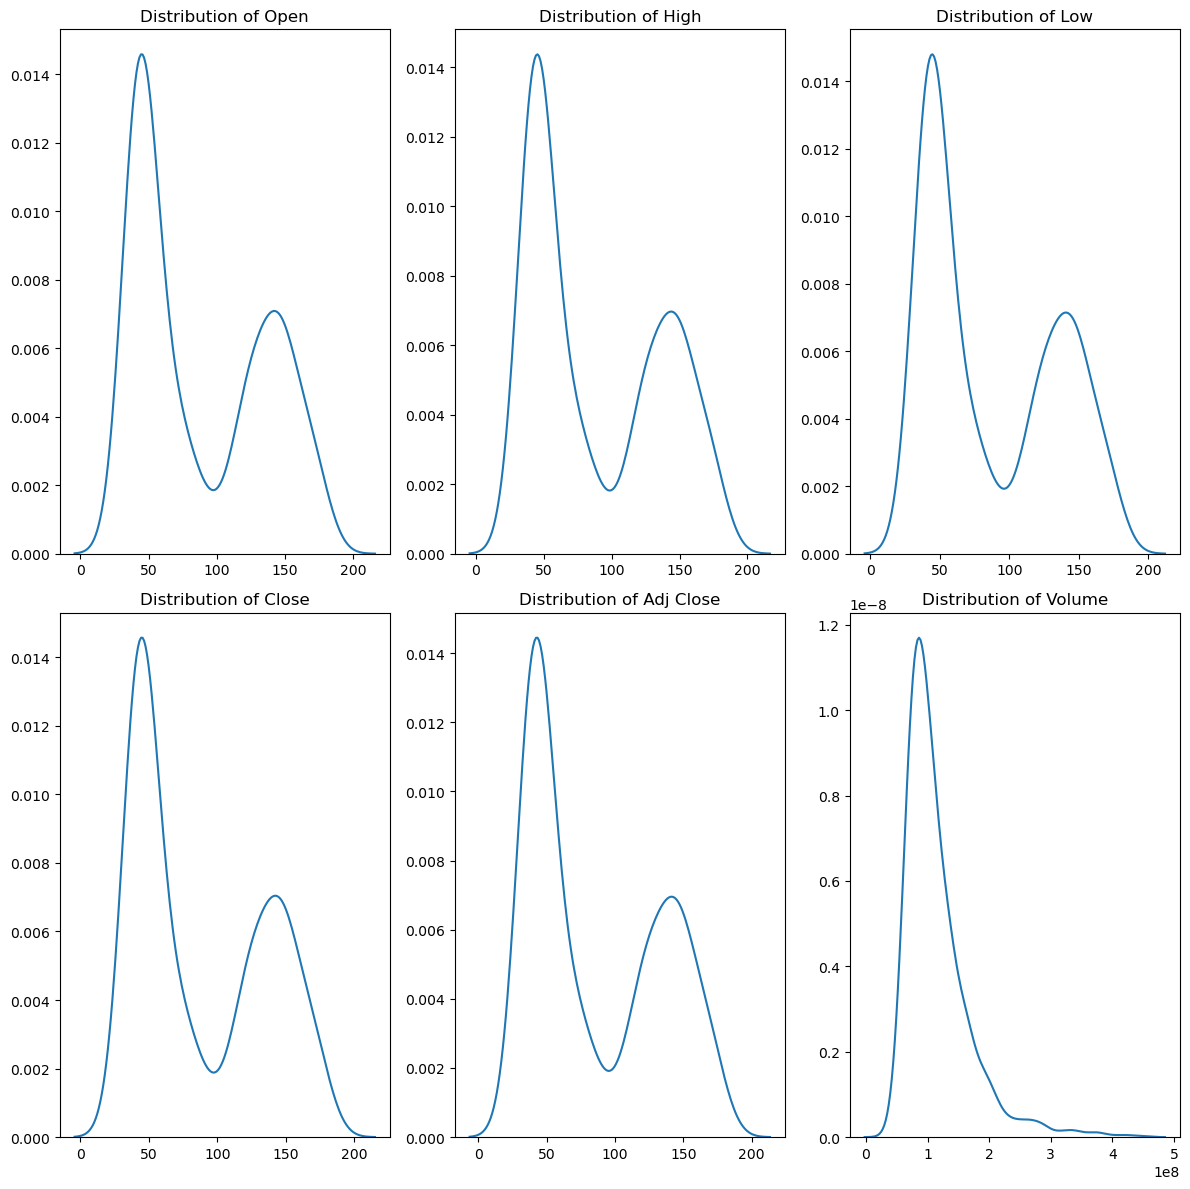

In [12]:
# Creating distributions for all the continuous variables

plt.figure(figsize=(12, 12))
for i, feature in enumerate(df_features, 1):
    plt.subplot(num_of_rows, num_of_cols, i)
    sns.kdeplot(data=df, x=feature)
    plt.title(f'Distribution of {feature}')
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

In [13]:
print(df.corr())

               Open      High       Low     Close  Adj Close    Volume
Open       1.000000  0.999782  0.999723  0.999412   0.999390 -0.248745
High       0.999782  1.000000  0.999685  0.999724   0.999715 -0.242900
Low        0.999723  0.999685  1.000000  0.999734   0.999697 -0.256443
Close      0.999412  0.999724  0.999734  1.000000   0.999972 -0.250022
Adj Close  0.999390  0.999715  0.999697  0.999972   1.000000 -0.250061
Volume    -0.248745 -0.242900 -0.256443 -0.250022  -0.250061  1.000000


In [22]:
# Feature Scaling
X_features = X.columns
min_max_scaler_instance = MinMaxScaler(feature_range = (0, 1))
X = pd.DataFrame(min_max_scaler_instance.fit_transform(X), columns = X_features)


In [23]:
# Train and Test Split
train_set_scaled, test_set_scaled, y_train_set, y_test_set = train_test_split(X, y, test_size = 0.2,
                                                                              random_state = 42, shuffle = False)

In [24]:
def create_dataset(X, y, time_steps=1):
    """
    This function will prepare the data, using the time steps, for training and testing.
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [25]:
# Create the dataset
time_steps = 30
test_extended = pd.concat([train_set_scaled.tail(time_steps), test_set_scaled], axis = 0)
y_test_extended = pd.concat([y_train_set.tail(time_steps), y_test_set], axis = 0)

X_train, y_train = create_dataset(train_set_scaled, y_train_set, time_steps)
X_test, y_test = create_dataset(test_extended, y_test_extended, time_steps)

In [26]:
# Function to plot the actual vs predicted values for a model
def plot_result(y_test, y_preds, time_steps, model_name = None):
    # Plotting the actual test values
    plt.figure(figsize=(10, 5))
    plt.plot(y_test[time_steps:], label='True', color='blue')

    # Plotting the predicted values
    plt.plot(y_preds[time_steps:], label='Predicted', color='red', linestyle='dashed')

    if model_name != None:
        plt.title(f'{model_name} - Actual vs Predicted')
    else:
        plt.title('Actual vs Predicted')

    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

In [27]:
# RNN Models

In [28]:
class TimeSeriesModel:
    def __init__(self, model_type='lstm', loss='mse', optimizer='adam', seed_value=42):
        self.model_type = model_type
        self.loss = loss
        self.optimizer = optimizer
        self.seed_value = seed_value
        self.best_model_path = None
        self.model = None

    def _setup_seed(self):
        np.random.seed(self.seed_value)
        random.seed(self.seed_value)
        tf.random.set_seed(self.seed_value)

    def define_model(self, X):
        X = X.copy()
        self._setup_seed()

        if self.model_type == 'lstm':
            self.model = Sequential()
            self.model.add(LSTM(64, input_shape=(X.shape[1], X.shape[2])))
        elif self.model_type == 'bi_lstm':
            self.model = Sequential()
            self.model.add(Bidirectional(LSTM(64), input_shape=(X.shape[1], X.shape[2])))
        elif self.model_type == 'gru':
            self.model = Sequential()
            self.model.add(GRU(64, input_shape=(X.shape[1], X.shape[2])))
        else:
            raise ValueError("Invalid model type. Choose 'lstm', 'bi_lstm', or 'gru'.")

        self.model.add(Dense(1))
        self.model.compile(loss=self.loss, optimizer=self.optimizer)

    def fit(self, X_train, y_train, X_test, y_test, epochs=1000, patience=50, best_model_path = 'Best_Model.keras'):
        self.best_model_path = best_model_path
        self.define_model(X_train)
        checkpoint = ModelCheckpoint(self.best_model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='min', restore_best_weights=True)

        self.model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

    def predict(self, X_test, verbose=False, best_model = True):
        if best_model == True:
            self.model.load_weights(self.best_model_path)
        else:
            pass
        return self.model.predict(X_test, verbose=verbose)

In [29]:
# LSTM Model

In [30]:
# Adam optimizer 

In [31]:
# Creating an instance of the class
lstm_adam_model = TimeSeriesModel(model_type='lstm')
# Training the model
lstm_adam_model.fit(X_train, y_train, X_test, y_test, best_model_path = 'Best_LSTM_Model_ADAM_Optimizer.h5')



Epoch 1/1000

33/37 [=========================>....] - ETA: 0s - loss: 6107.5278
Epoch 1: val_loss improved from inf to 21994.57031, saving model to Best_LSTM_Model_ADAM_Optimizer.h5
37/37 [==============================] - 4s 34ms/step - loss: 6058.5923 - val_loss: 21994.5703
Epoch 2/1000
11/37 [=======>......................] - ETA: 0s - loss: 5036.5898

C:\Users\Asus\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/37 [==========================>...] - ETA: 0s - loss: 5147.4126
Epoch 2: val_loss improved from 21994.57031 to 20600.63672, saving model to Best_LSTM_Model_ADAM_Optimizer.h5
37/37 [==============================] - 0s 13ms/step - loss: 5113.2437 - val_loss: 20600.6367
Epoch 3/1000
35/37 [===========================>..] - ETA: 0s - loss: 4657.9668
Epoch 3: val_loss improved from 20600.63672 to 19773.83008, saving model to Best_LSTM_Model_ADAM_Optimizer.h5
37/37 [==============================] - 1s 16ms/step - loss: 4688.0776 - val_loss: 19773.8301
Epoch 4/1000
33/37 [=========================>....] - ETA: 0s - loss: 4388.2100
Epoch 4: val_loss improved from 19773.83008 to 19055.87305, saving model to Best_LSTM_Model_ADAM_Optimizer.h5
37/37 [==============================] - 1s 15ms/step - loss: 4379.5669 - val_loss: 19055.8730
Epoch 5/1000
36/37 [============================>.] - ETA: 0s - loss: 4105.5122
Epoch 5: val_loss improved from 19055.87305 to 18391.71289, saving model to Be

In [33]:
# Making predictions
y_preds = lstm_adam_model.predict(X_test)

In [34]:
# Calculating RMSE and R^2 Score
rmse = mean_squared_error(y_test[time_steps:], y_preds[time_steps:], squared=False)
r2 = r2_score(y_test[time_steps:], y_preds[time_steps:])

print(f'RMSE: {rmse}')
print("R2 Score:", r2)

RMSE: 8.514209414520915
R2 Score: 0.6078051228392574


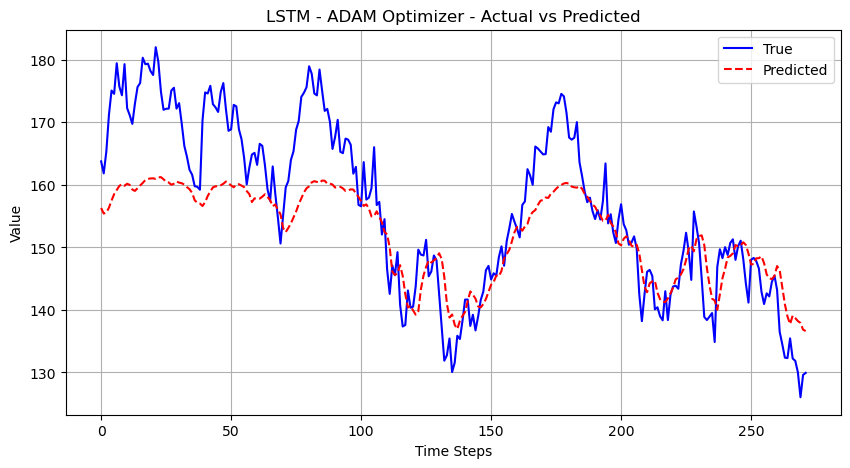

In [35]:
plot_result(y_test, y_preds, time_steps, model_name = 'LSTM - ADAM Optimizer')

In [ ]:
# SGD Optimizer

In [36]:
# Creating an instance of the class
lstm_sgd_model = TimeSeriesModel(model_type='lstm', optimizer = 'sgd')
# Train the model
lstm_sgd_model.fit(X_train, y_train, X_test, y_test, best_model_path = 'Best_LSTM_Model_SGD_Optimizer.h5')

Epoch 1/1000
34/37 [==========================>...] - ETA: 0s - loss: 1772.6560
Epoch 1: val_loss improved from inf to 7312.22119, saving model to Best_LSTM_Model_SGD_Optimizer.h5
37/37 [==============================] - 4s 35ms/step - loss: 1729.2675 - val_loss: 7312.2212
Epoch 2/1000
11/37 [=======>......................] - ETA: 0s - loss: 1246.8459

C:\Users\Asus\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


35/37 [===========================>..] - ETA: 0s - loss: 1346.1215
Epoch 2: val_loss did not improve from 7312.22119
37/37 [==============================] - 1s 14ms/step - loss: 1327.1902 - val_loss: 8092.1450
Epoch 3/1000
36/37 [============================>.] - ETA: 0s - loss: 1194.2075
Epoch 3: val_loss improved from 7312.22119 to 3277.69507, saving model to Best_LSTM_Model_SGD_Optimizer.h5
37/37 [==============================] - 0s 13ms/step - loss: 1184.5939 - val_loss: 3277.6951
Epoch 4/1000
32/37 [========================>.....] - ETA: 0s - loss: 557.2372
Epoch 4: val_loss improved from 3277.69507 to 462.17197, saving model to Best_LSTM_Model_SGD_Optimizer.h5
37/37 [==============================] - 1s 14ms/step - loss: 489.0082 - val_loss: 462.1720
Epoch 5/1000
37/37 [==============================] - ETA: 0s - loss: 19.3009
Epoch 5: val_loss improved from 462.17197 to 303.90161, saving model to Best_LSTM_Model_SGD_Optimizer.h5
37/37 [==============================] - 1s 17ms

In [37]:
# Making predictions
y_preds = lstm_sgd_model.predict(X_test)

In [38]:
# Calculating RMSE and R^2 Score
rmse = mean_squared_error(y_test[time_steps:], y_preds[time_steps:], squared=False)
r2 = r2_score(y_test[time_steps:], y_preds[time_steps:])

print(f'RMSE: {rmse}')
print("R2 Score:", r2)

RMSE: 4.438036629701268
R2 Score: 0.8934398002906807


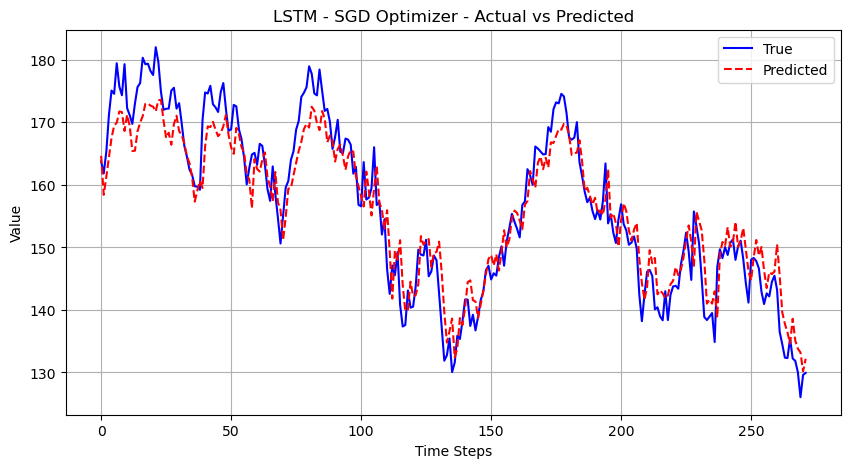

In [39]:
plot_result(y_test, y_preds, time_steps, model_name = 'LSTM - SGD Optimizer')

In [40]:
# RMSprop optimizer

In [41]:
# Creating an instance of the class
lstm_rmsprop_model = TimeSeriesModel(model_type='lstm', optimizer = RMSprop(learning_rate=0.001))
# Train the model
lstm_rmsprop_model.fit(X_train, y_train, X_test, y_test, best_model_path = 'Best_LSTM_Model_RMSprop_Optimizer.h5')

Epoch 1/1000
34/37 [==========================>...] - ETA: 0s - loss: 5700.8467
Epoch 1: val_loss improved from inf to 21339.31445, saving model to Best_LSTM_Model_RMSprop_Optimizer.h5
37/37 [==============================] - 4s 33ms/step - loss: 5660.6763 - val_loss: 21339.3145
Epoch 2/1000
11/37 [=======>......................] - ETA: 0s - loss: 4816.9019

C:\Users\Asus\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - ETA: 0s - loss: 4973.0449
Epoch 2: val_loss improved from 21339.31445 to 20448.07031, saving model to Best_LSTM_Model_RMSprop_Optimizer.h5
37/37 [==============================] - 1s 14ms/step - loss: 4973.0449 - val_loss: 20448.0703
Epoch 3/1000
33/37 [=========================>....] - ETA: 0s - loss: 4703.2314
Epoch 3: val_loss improved from 20448.07031 to 19724.43359, saving model to Best_LSTM_Model_RMSprop_Optimizer.h5
37/37 [==============================] - 0s 13ms/step - loss: 4648.1353 - val_loss: 19724.4336
Epoch 4/1000
33/37 [=========================>....] - ETA: 0s - loss: 4376.9614
Epoch 4: val_loss improved from 19724.43359 to 19053.44336, saving model to Best_LSTM_Model_RMSprop_Optimizer.h5
37/37 [==============================] - 1s 16ms/step - loss: 4369.2183 - val_loss: 19053.4434
Epoch 5/1000
36/37 [============================>.] - ETA: 0s - loss: 4109.3711
Epoch 5: val_loss improved from 19053.44336 to 18407.07422, saving mo

In [42]:
# Making predictions
y_preds = lstm_rmsprop_model.predict(X_test)

In [43]:
# Calculating RMSE and R^2 Score
rmse = mean_squared_error(y_test[time_steps:], y_preds[time_steps:], squared=False)
r2 = r2_score(y_test[time_steps:], y_preds[time_steps:])

print(f'RMSE: {rmse}')
print("R2 Score:", r2)

RMSE: 11.990821285586014
R2 Score: 0.22212265837737477


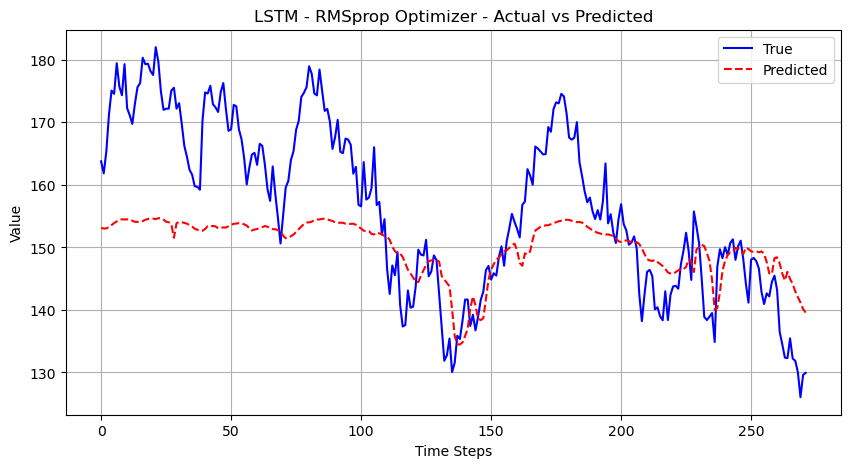

In [44]:
plot_result(y_test, y_preds, time_steps, model_name = 'LSTM - RMSprop Optimizer')

In [47]:
# BiLSTM Model

In [ ]:
# Adam Optimizer

In [48]:
# Creating an instance of the class
bi_lstm_adam_model = TimeSeriesModel(model_type='bi_lstm')
# Train the model
bi_lstm_adam_model.fit(X_train, y_train, X_test, y_test, best_model_path = 'Best_BiLSTM_Model_ADAM_Optimizer.h5')

Epoch 1/1000
35/37 [===========================>..] - ETA: 0s - loss: 5939.6616
Epoch 1: val_loss improved from inf to 20934.76758, saving model to Best_BiLSTM_Model_ADAM_Optimizer.h5
37/37 [==============================] - 6s 58ms/step - loss: 5901.3994 - val_loss: 20934.7676
Epoch 2/1000
36/37 [============================>.] - ETA: 0s - loss: 4515.1880
Epoch 2: val_loss improved from 20934.76758 to 18626.75391, saving model to Best_BiLSTM_Model_ADAM_Optimizer.h5
37/37 [==============================] - 1s 19ms/step - loss: 4484.7456 - val_loss: 18626.7539
Epoch 3/1000
36/37 [============================>.] - ETA: 0s - loss: 3796.8950
Epoch 3: val_loss improved from 18626.75391 to 17187.13672, saving model to Best_BiLSTM_Model_ADAM_Optimizer.h5
37/37 [==============================] - 1s 18ms/step - loss: 3802.9897 - val_loss: 17187.1367
Epoch 4/1000
35/37 [===========================>..] - ETA: 0s - loss: 3297.6262
Epoch 4: val_loss improved from 17187.13672 to 15962.90918, saving 

In [49]:
# Making predictions
y_preds = bi_lstm_adam_model.predict(X_test)

In [50]:
# Calculating RMSE and R^2 Score
rmse = mean_squared_error(y_test[time_steps:], y_preds[time_steps:], squared=False)
r2 = r2_score(y_test[time_steps:], y_preds[time_steps:])

print(f'RMSE: {rmse}')
print("R2 Score:", r2)

RMSE: 10.873805938866253
R2 Score: 0.36029990233547293


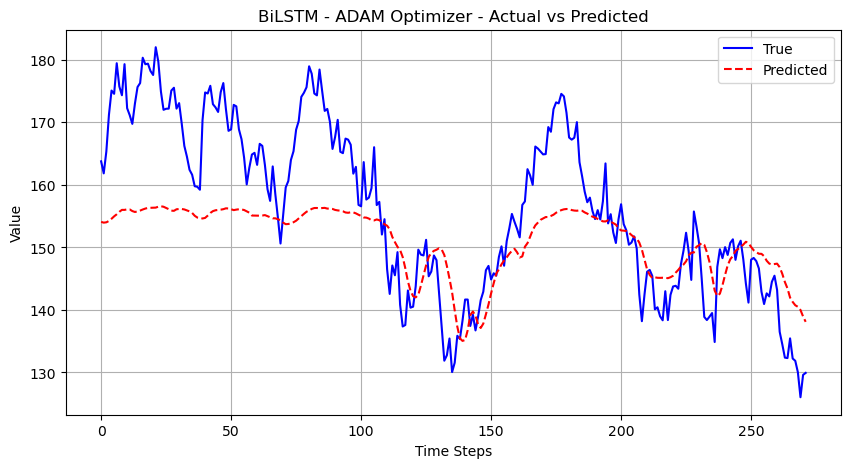

In [51]:
plot_result(y_test, y_preds, time_steps, model_name = 'BiLSTM - ADAM Optimizer')

In [52]:
# SGD Optimizer

In [53]:
# Creating an instance of the class
bi_lstm_sgd_model = TimeSeriesModel(model_type='bi_lstm', optimizer = 'sgd')
# Train the model
bi_lstm_sgd_model.fit(X_train, y_train, X_test, y_test, best_model_path = 'Best_BiLSTM_Model_SGD_Optimizer.h5')

Epoch 1/1000
35/37 [===========================>..] - ETA: 0s - loss: 1719.5455
Epoch 1: val_loss improved from inf to 9644.55078, saving model to Best_BiLSTM_Model_SGD_Optimizer.h5
37/37 [==============================] - 7s 42ms/step - loss: 1681.9575 - val_loss: 9644.5508
Epoch 2/1000
12/37 [========>.....................] - ETA: 0s - loss: 599.2544

C:\Users\Asus\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/37 [=========================>....] - ETA: 0s - loss: 896.4873
Epoch 2: val_loss improved from 9644.55078 to 1224.89978, saving model to Best_BiLSTM_Model_SGD_Optimizer.h5
37/37 [==============================] - 1s 15ms/step - loss: 871.9130 - val_loss: 1224.8998
Epoch 3/1000
33/37 [=========================>....] - ETA: 0s - loss: 105.0621
Epoch 3: val_loss improved from 1224.89978 to 194.53154, saving model to Best_BiLSTM_Model_SGD_Optimizer.h5
37/37 [==============================] - 1s 14ms/step - loss: 105.8359 - val_loss: 194.5315
Epoch 4/1000
37/37 [==============================] - ETA: 0s - loss: 24.6715
Epoch 4: val_loss did not improve from 194.53154
37/37 [==============================] - 1s 14ms/step - loss: 24.6715 - val_loss: 564.9063
Epoch 5/1000
33/37 [=========================>....] - ETA: 0s - loss: 21.6789
Epoch 5: val_loss improved from 194.53154 to 119.08791, saving model to Best_BiLSTM_Model_SGD_Optimizer.h5
37/37 [==============================] - 1s 15ms/s

In [54]:
# Making predictions
y_preds = bi_lstm_sgd_model.predict(X_test)

In [55]:
# Calculating RMSE and R^2 Score
rmse = mean_squared_error(y_test[time_steps:], y_preds[time_steps:], squared=False)
r2 = r2_score(y_test[time_steps:], y_preds[time_steps:])

print(f'RMSE: {rmse}')
print("R2 Score:", r2)

RMSE: 4.161842439390544
R2 Score: 0.9062903037916432


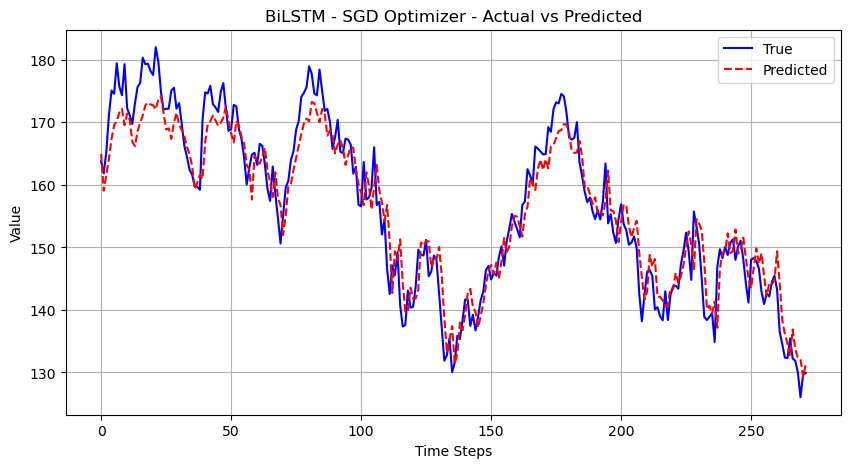

In [56]:
plot_result(y_test, y_preds, time_steps, model_name = 'BiLSTM - SGD Optimizer')

In [ ]:
# RMSprop Optimizer

In [57]:
# Creating an instance of the class
bi_lstm_rmsprop_model = TimeSeriesModel(model_type='bi_lstm', optimizer = RMSprop(learning_rate=0.001))
# Train the model
bi_lstm_rmsprop_model.fit(X_train, y_train, X_test, y_test, best_model_path = 'Best_BiLSTM_Model_RMSprop_Optimizer.h5')

Epoch 1/1000
37/37 [==============================] - ETA: 0s - loss: 5274.6021
Epoch 1: val_loss improved from inf to 19810.49023, saving model to Best_BiLSTM_Model_RMSprop_Optimizer.h5
37/37 [==============================] - 7s 45ms/step - loss: 5274.6021 - val_loss: 19810.4902
Epoch 2/1000
11/37 [=======>......................] - ETA: 0s - loss: 4172.1870

C:\Users\Asus\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - ETA: 0s - loss: 4219.6299
Epoch 2: val_loss improved from 19810.49023 to 18251.96680, saving model to Best_BiLSTM_Model_RMSprop_Optimizer.h5
37/37 [==============================] - 1s 15ms/step - loss: 4219.6299 - val_loss: 18251.9668
Epoch 3/1000
36/37 [============================>.] - ETA: 0s - loss: 3679.8037
Epoch 3: val_loss improved from 18251.96680 to 16890.71289, saving model to Best_BiLSTM_Model_RMSprop_Optimizer.h5
37/37 [==============================] - 1s 15ms/step - loss: 3686.0288 - val_loss: 16890.7129
Epoch 4/1000
36/37 [============================>.] - ETA: 0s - loss: 3232.6641
Epoch 4: val_loss improved from 16890.71289 to 15685.41895, saving model to Best_BiLSTM_Model_RMSprop_Optimizer.h5
37/37 [==============================] - 1s 15ms/step - loss: 3229.3525 - val_loss: 15685.4189
Epoch 5/1000
37/37 [==============================] - ETA: 0s - loss: 2853.0110
Epoch 5: val_loss improved from 15685.41895 to 14555.42676, sav

In [58]:
# Making predictions
y_preds = bi_lstm_rmsprop_model.predict(X_test)

In [59]:
# Calculating RMSE and R^2 Score
rmse = mean_squared_error(y_test[time_steps:], y_preds[time_steps:], squared=False)
r2 = r2_score(y_test[time_steps:], y_preds[time_steps:])

print(f'RMSE: {rmse}')
print("R2 Score:", r2)

RMSE: 13.583313460969167
R2 Score: 0.001783585770587126


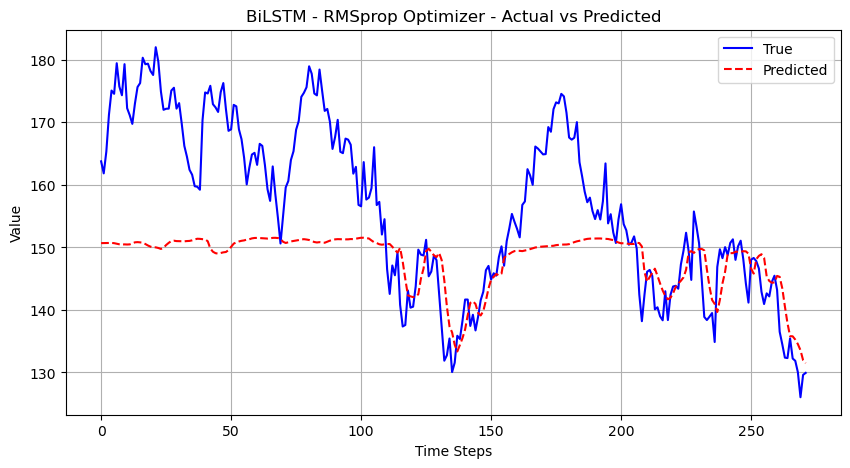

In [60]:
plot_result(y_test, y_preds, time_steps, model_name = 'BiLSTM - RMSprop Optimizer')

In [61]:
 # GRU model

In [62]:
# Adam optimizer

In [63]:
# Creating an instance of the class
gru_adam_model = TimeSeriesModel(model_type='gru')
# Train the model
gru_adam_model.fit(X_train, y_train, X_test, y_test, best_model_path = 'Best_GRU_Model_ADAM_Optimizer.h5')

Epoch 1/1000
35/37 [===========================>..] - ETA: 0s - loss: 6302.6206
Epoch 1: val_loss improved from inf to 21872.72070, saving model to Best_GRU_Model_ADAM_Optimizer.h5
37/37 [==============================] - 5s 38ms/step - loss: 6267.0181 - val_loss: 21872.7207
Epoch 2/1000
11/37 [=======>......................] - ETA: 0s - loss: 4984.3457

C:\Users\Asus\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/37 [=========================>....] - ETA: 0s - loss: 5090.0625
Epoch 2: val_loss improved from 21872.72070 to 20496.82812, saving model to Best_GRU_Model_ADAM_Optimizer.h5
37/37 [==============================] - 1s 14ms/step - loss: 5062.5835 - val_loss: 20496.8281
Epoch 3/1000
37/37 [==============================] - ETA: 0s - loss: 4636.6060
Epoch 3: val_loss improved from 20496.82812 to 19638.78906, saving model to Best_GRU_Model_ADAM_Optimizer.h5
37/37 [==============================] - 1s 17ms/step - loss: 4636.6060 - val_loss: 19638.7891
Epoch 4/1000
34/37 [==========================>...] - ETA: 0s - loss: 4295.7656
Epoch 4: val_loss improved from 19638.78906 to 18907.04688, saving model to Best_GRU_Model_ADAM_Optimizer.h5
37/37 [==============================] - 1s 18ms/step - loss: 4323.2646 - val_loss: 18907.0469
Epoch 5/1000
36/37 [============================>.] - ETA: 0s - loss: 4046.1238
Epoch 5: val_loss improved from 18907.04688 to 18231.39258, saving model to Best_

In [64]:
# Making predictions
y_preds = gru_adam_model.predict(X_test)

In [65]:
# Calculating RMSE and R^2 Score
rmse = mean_squared_error(y_test[time_steps:], y_preds[time_steps:], squared=False)
r2 = r2_score(y_test[time_steps:], y_preds[time_steps:])

print(f'RMSE: {rmse}')
print("R2 Score:", r2)

RMSE: 7.803936590095737
R2 Score: 0.6705111482519727


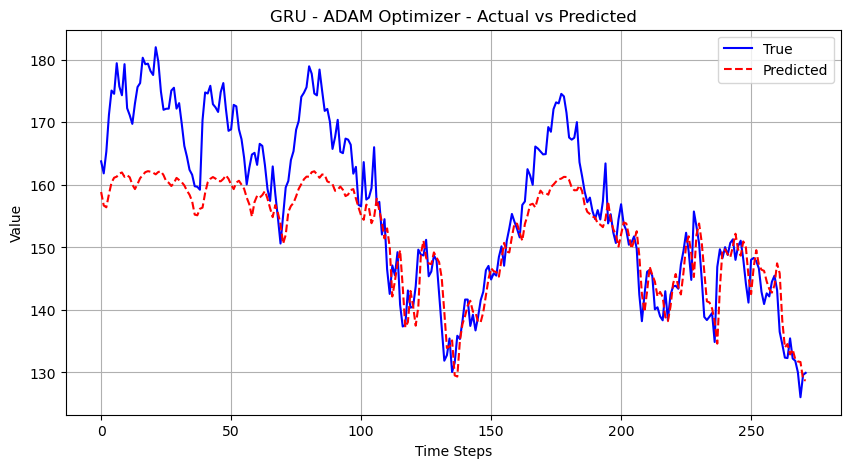

In [66]:
plot_result(y_test, y_preds, time_steps, model_name = 'GRU - ADAM Optimizer')

In [67]:
# SGD optimizer

In [68]:
# Creating an instance of the class
gru_sgd_model = TimeSeriesModel(model_type='gru', optimizer = 'sgd')
# Train the model
gru_sgd_model.fit(X_train, y_train, X_test, y_test, best_model_path = 'Best_GRU_Model_SGD_Optimizer.h5')

Epoch 1/1000
35/37 [===========================>..] - ETA: 0s - loss: 1289.2008
Epoch 1: val_loss improved from inf to 684.25623, saving model to Best_GRU_Model_SGD_Optimizer.h5
37/37 [==============================] - 3s 27ms/step - loss: 1228.8191 - val_loss: 684.2562
Epoch 2/1000
10/37 [=======>......................] - ETA: 0s - loss: 25.7564

C:\Users\Asus\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


34/37 [==========================>...] - ETA: 0s - loss: 36.8369
Epoch 2: val_loss improved from 684.25623 to 344.74915, saving model to Best_GRU_Model_SGD_Optimizer.h5
37/37 [==============================] - 1s 14ms/step - loss: 34.8081 - val_loss: 344.7491
Epoch 3/1000
35/37 [===========================>..] - ETA: 0s - loss: 40.7431
Epoch 3: val_loss did not improve from 344.74915
37/37 [==============================] - 0s 13ms/step - loss: 39.4545 - val_loss: 364.4130
Epoch 4/1000
35/37 [===========================>..] - ETA: 0s - loss: 36.3977
Epoch 4: val_loss improved from 344.74915 to 259.93732, saving model to Best_GRU_Model_SGD_Optimizer.h5
37/37 [==============================] - 1s 14ms/step - loss: 36.1442 - val_loss: 259.9373
Epoch 5/1000
36/37 [============================>.] - ETA: 0s - loss: 8.8762
Epoch 5: val_loss improved from 259.93732 to 185.14108, saving model to Best_GRU_Model_SGD_Optimizer.h5
37/37 [==============================] - 1s 14ms/step - loss: 9.2384

In [69]:
# Make predictions
y_preds = gru_sgd_model.predict(X_test)

In [70]:
# Calculating RMSE and R^2 Score
rmse = mean_squared_error(y_test[time_steps:], y_preds[time_steps:], squared=False)
r2 = r2_score(y_test[time_steps:], y_preds[time_steps:])

print(f'RMSE: {rmse}')
print("R2 Score:", r2)

RMSE: 8.40073144599924
R2 Score: 0.6181898549353229


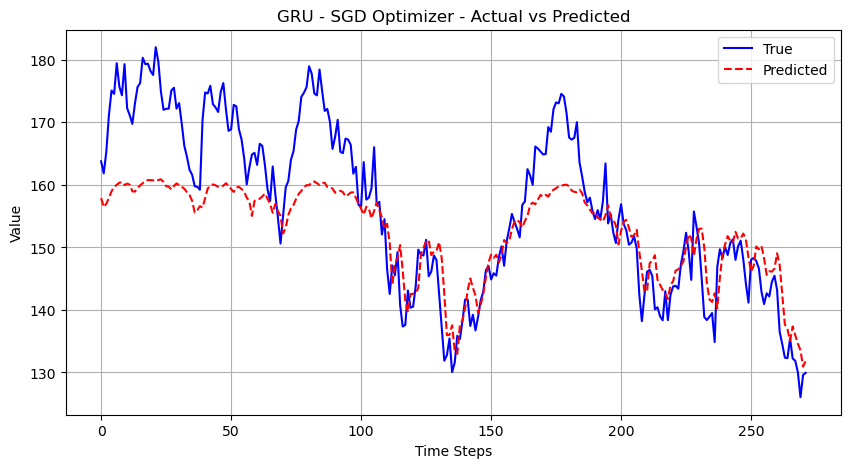

In [71]:
plot_result(y_test, y_preds, time_steps, model_name = 'GRU - SGD Optimizer')

In [72]:
# RMSprop optimizer

In [73]:
# Creating an instance of the class
gru_rmsprop_model = TimeSeriesModel(model_type='gru', optimizer = RMSprop(learning_rate=0.001))
# Train the model
gru_rmsprop_model.fit(X_train, y_train, X_test, y_test, best_model_path = 'Best_GRU_Model_RMSprop_Optimizer.h5')

Epoch 1/1000
33/37 [=========================>....] - ETA: 0s - loss: 5767.7549
Epoch 1: val_loss improved from inf to 21120.31836, saving model to Best_GRU_Model_RMSprop_Optimizer.h5
37/37 [==============================] - 4s 34ms/step - loss: 5711.1304 - val_loss: 21120.3184
Epoch 2/1000
 9/37 [======>.......................] - ETA: 0s - loss: 4784.0688

C:\Users\Asus\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/37 [============================>.] - ETA: 0s - loss: 4928.2749
Epoch 2: val_loss improved from 21120.31836 to 20320.98438, saving model to Best_GRU_Model_RMSprop_Optimizer.h5
37/37 [==============================] - 1s 16ms/step - loss: 4901.2012 - val_loss: 20320.9844
Epoch 3/1000
34/37 [==========================>...] - ETA: 0s - loss: 4596.4067
Epoch 3: val_loss improved from 20320.98438 to 19639.59180, saving model to Best_GRU_Model_RMSprop_Optimizer.h5
37/37 [==============================] - 1s 16ms/step - loss: 4607.5718 - val_loss: 19639.5918
Epoch 4/1000
34/37 [==========================>...] - ETA: 0s - loss: 4307.6338
Epoch 4: val_loss improved from 19639.59180 to 18974.37305, saving model to Best_GRU_Model_RMSprop_Optimizer.h5
37/37 [==============================] - 1s 16ms/step - loss: 4336.2319 - val_loss: 18974.3730
Epoch 5/1000
35/37 [===========================>..] - ETA: 0s - loss: 4122.9580
Epoch 5: val_loss improved from 18974.37305 to 18332.02734, saving model

In [74]:
# Making predictions
y_preds = gru_rmsprop_model.predict(X_test)

In [75]:
# Calculating RMSE and R^2 Score
rmse = mean_squared_error(y_test[time_steps:], y_preds[time_steps:], squared=False)
r2 = r2_score(y_test[time_steps:], y_preds[time_steps:])

print(f'RMSE: {rmse}')
print("R2 Score:", r2)

RMSE: 7.409858403454994
R2 Score: 0.7029475907829502


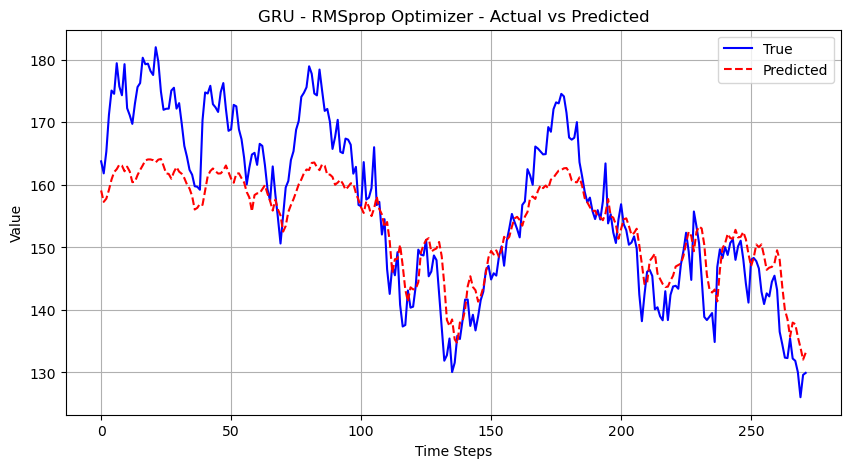

In [76]:
plot_result(y_test, y_preds, time_steps, model_name = 'GRU - RMSprop Optimizer')